In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.autograd import Variable
from torch.utils.serialization import load_lua
from torch.utils.data import DataLoader

from torchvision import transforms, models, datasets

import numpy as np

from PIL import Image
import matplotlib
import matplotlib.pyplot as plt

import copy

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
matplotlib.rc('figure', figsize=(12, 5))

In [2]:
use_cuda = torch.cuda.is_available()
use_cuda

True

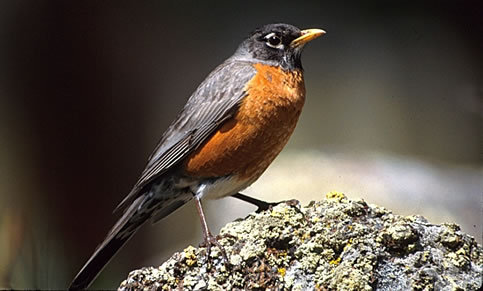

In [3]:
image = Image.open('data/bird.png')
image

## Image processing

In [6]:
# preproces PIL image
# return tensor of shape (batch, channels, height, width)
preprocess = transforms.Compose([
    transforms.Scale(512),
    transforms.ToTensor(),
    transforms.Normalize(mean = [ 0.485, 0.456, 0.406 ],
                          std = [ 0.229, 0.224, 0.225 ]),
    transforms.Lambda(lambda x: x.unsqueeze(0))
])

In [7]:
image_arr = preprocess(image)
original_image_shape = image_arr.shape

In [9]:
img_var = Variable(image_arr)

## Load pretrained model

In [6]:
resnet = models.resnet101(pretrained=True)
resnet

ResNet (
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
  (relu): ReLU (inplace)
  (maxpool): MaxPool2d (size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=(1, 1))
  (layer1): Sequential (
    (0): Bottleneck (
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU (inplace)
      (downsample): Sequential (
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
      )
    )
    (1): Bott

In [ ]:
resnet.

In [4]:
vgg = models.vgg16(pretrained=True).features
# vgg = vgg.cuda()
vgg

Sequential (
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU (inplace)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU (inplace)
  (4): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU (inplace)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU (inplace)
  (9): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU (inplace)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU (inplace)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU (inplace)
  (16): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
  (17): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (18): ReLU (inplace)
  (19): Conv2d(512,

In [12]:
vgg((Variable(image_arr)))

Variable containing:
( 0 , 0 ,.,.) = 
   0.0000   0.0000   0.0000  ...    0.0000   0.0000   0.0000
   0.0000   0.0000   0.0000  ...    0.0000   0.0000   0.0000
   0.0000   0.0000   0.0000  ...    0.0000   0.0000   0.0000
            ...               ⋱              ...            
   0.0000   0.0000   0.0000  ...    1.4889   1.8304   0.0000
   0.0000   0.0000   0.0000  ...    1.3773   1.3815   1.6963
   0.0000   0.0000   0.0000  ...    1.5885   1.6330   1.3227

( 0 , 1 ,.,.) = 
   0.0000   0.0000   0.0000  ...    0.0000   0.0000   0.0000
   0.0000   0.0000   0.0000  ...    0.0000   0.0000   0.0000
   0.0000   0.0000   0.0000  ...    0.0000   0.0000   0.0000
            ...               ⋱              ...            
   0.0000   0.0000   0.0000  ...    0.0000   0.0000   0.0000
   0.0000   0.0000   0.0000  ...    0.0000   0.0000   0.5897
   0.0000   0.0000   0.0000  ...    0.0000   0.0000   0.0000

( 0 , 2 ,.,.) = 
   0.0000   0.0000   0.0000  ...    0.0000   0.0000   0.0000
   0.0000  

In [ ]:
inception = models.inception_v3(pretrained=True)
inception = list(inception.children())

In [ ]:
len(inception)

In [ ]:
def show(img, layer_idx, filter_idx):
    layers = [inception[i] for i in range(0, layer_idx+1)]
    model = nn.Sequential(*layers).cuda()
    out = model(img)
    model = None
    out.squeeze_()
    print(out.shape)
    plt.figure()
    plt.imshow(out[filter_idx].data)

In [ ]:
%%time
show(img_var, layer_idx=1, filter_idx=31);